In [9]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from tqdm import tqdm

from transformers import RobertaModel, RobertaTokenizer

In [10]:
def load_dataframe(path: str) -> pd.DataFrame:
    return pd.read_csv(path)

In [11]:
def clean_data(df):
    df['text'] = df['text'].str.replace('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', ' ')
    df["text"] = df['text'].str.replace(" +", " ", regex=True)

    return df
    
def prepare_dataframe(df: pd.DataFrame, minimum_contribution = 500) -> pd.DataFrame:
    developers = df["owner"].value_counts()
    filtered_developers = developers.index[developers >= minimum_contribution]
    df = df[df["owner"].isin(filtered_developers)]

    df["text"] = df.apply(lambda x: str(x["issue_title"]) + "\n" + str(x["description"]), axis=1)
    df["owner_id"] = pd.factorize(df["owner"])[0]

    min_length = 15
    df = df[df["text"].str.len().gt(min_length)]

    return df

In [17]:
data_path = "./data/deeptriage/classifier_data_0.csv"

df = load_dataframe(data_path)
df = prepare_dataframe(df)
df = clean_data(df)

/tmp/ipykernel_1139865/1987391481.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["text"] = df.apply(lambda x: str(x["issue_title"]) + "\n" + str(x["description"]), axis=1)
/tmp/ipykernel_1139865/1987391481.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["owner_id"] = pd.factorize(df["owner"])[0]


In [18]:
print(df.iloc[3220]["text"])

No repost warning dialog in Mac
Chrome Version : 4.0.212.1OS version : 10.6.1Behavior in Safari 3.x/4.x (if applicable): Ask for resubmitBehavior in Firefox 3.x (if applicable): Ask for resubmitBehavior in Chrome for Windows:What steps will reproduce the problem?1.Any HTTP-POST formexample: go to http://www.cs.unc.edu/~jbs/resources/perl/perl-cgi/programs/form1-POST.html2. POST3. refresh -> no request and no confirmationWhat is the expected result?A confirmation about resubmitting the form. Very annoying when it's not available during website developmentWhat happens instead?nothing 


In [19]:



print(len(df))

8862


<Axes: ylabel='count'>

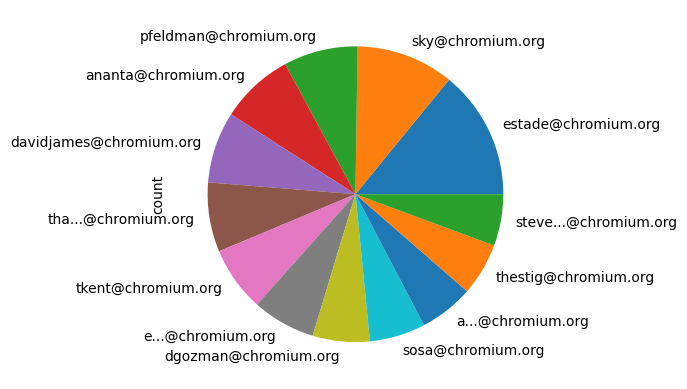

In [20]:
df["owner"].value_counts().plot(kind="pie")

In [21]:
np.random.seed(112)
df_train, df_val, df_test = np.split(df.sample(frac=1, random_state=42),
                                     [int(.8*len(df)), int(.9*len(df))])

print(len(df_train),len(df_val), len(df_test))

7089 886 887


/home/mdafifal.mamun/miniconda3/envs/playground/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [22]:
df_val["owner"].value_counts()

owner
estade@chromium.org        139
sky@chromium.org            91
pfeldman@chromium.org       78
ananta@chromium.org         73
dgozman@chromium.org        71
davidjames@chromium.org     68
tha...@chromium.org         62
e...@chromium.org           59
tkent@chromium.org          55
thestig@chromium.org        53
sosa@chromium.org           53
steve...@chromium.org       51
a...@chromium.org           33
Name: count, dtype: int64

In [23]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, df, model_name):
        self.tokenizer = RobertaTokenizer.from_pretrained(model_name)
        self.labels = [label for label in df['owner_id']]
        self.texts = [self.tokenizer(text,
                               padding='max_length', max_length = 512, truncation=True,
                                return_tensors="pt") for text in df['text']]

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y

In [24]:
class LBTLikeClassifier(nn.Module):
    def __init__(self, model_name: str, output_size, num_filters=256, bert_layers=4, embed_size=768, dropout = 0.1) -> None:
        super().__init__()
        self.base_model = RobertaModel.from_pretrained(model_name, output_hidden_states=True)
        filter_sizes = [3, 4, 5, 6]
        self.num_filters = num_filters
        self.bert_layers = bert_layers
        self.convs1 = nn.ModuleList([nn.Conv2d(self.bert_layers, num_filters, (K, embed_size)) for K in filter_sizes])
        self.dropout = nn.Dropout(dropout)
        self.fc1 = nn.Linear(len(filter_sizes)*num_filters + embed_size, output_size)
        self.relu = nn.ReLU()

    def forward(self, input_ids, attention_mask):
        x = self.base_model(input_ids, attention_mask = attention_mask)
        hidden_states = x["hidden_states"][-self.bert_layers:]
        pooler_output = x["pooler_output"]
        x = torch.stack(hidden_states, dim=1)
        x = [F.relu(conv(x)).squeeze(3) for conv in self.convs1]
        x = [F.max_pool1d(i, i.size(2)).squeeze(2) for i in x]
        x = torch.cat(x, 1)
        x = torch.cat([pooler_output, x], 1)
        x = self.dropout(x)
        logit = self.fc1(x)

        return self.relu(x)


In [25]:
class Classifier(nn.Module):
    def __init__(self, model_name: str, output_size, embed_size=768, dropout = 0.1) -> None:
        super().__init__()
        self.base_model = RobertaModel.from_pretrained(model_name, output_hidden_states=True)
        filter_sizes = [3, 4, 5, 6]
        num_filters = 256
        self.convs1 = nn.ModuleList([nn.Conv2d(4, num_filters, (K, embed_size)) for K in filter_sizes])
        self.dropout = nn.Dropout(dropout)
        self.fc1 = nn.Linear(len(filter_sizes)*num_filters, output_size)
        self.relu = nn.ReLU()

    def forward(self, input_ids, attention_mask):
        x = self.base_model(input_ids, attention_mask = attention_mask)[2][-4:]
        x = torch.stack(x, dim=1)
        x = [F.relu(conv(x)).squeeze(3) for conv in self.convs1] 
        x = [F.max_pool1d(i, i.size(2)).squeeze(2) for i in x]  
        x = torch.cat(x, 1)
        x = self.dropout(x)
        logit = self.fc1(x)  

        return self.relu(logit)


In [27]:
def train(model, train_data, val_data, learning_rate, epochs):
    model_name = "roberta-base"
    train, val = Dataset(train_data, model_name), Dataset(val_data, model_name)

    train_dataloader = torch.utils.data.DataLoader(train, batch_size=5, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=5)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=learning_rate)

    if use_cuda:

            model = model.cuda()
            criterion = criterion.cuda()

    for epoch_num in range(epochs):

            total_acc_train = 0
            total_loss_train = 0

            for train_input, train_label in tqdm(train_dataloader):
                # print(train_label)

                train_label = train_label.to(device)
                mask = train_input['attention_mask'].to(device)
                input_id = train_input['input_ids'].squeeze(1).to(device)

                output = model(input_id, mask)

                # print(output, train_label)
                # print(output.shape, train_label.shape)

                batch_loss = criterion(output, train_label.view(-1))
                total_loss_train += batch_loss.item()

                acc = (output.argmax(dim=1) == train_label).sum().item()
                total_acc_train += acc

                model.zero_grad()
                batch_loss.backward()
                optimizer.step()

            total_acc_val = 0
            total_loss_val = 0

            with torch.no_grad():

                for val_input, val_label in val_dataloader:

                    val_label = val_label.to(device)
                    mask = val_input['attention_mask'].to(device)
                    input_id = val_input['input_ids'].squeeze(1).to(device)

                    output = model(input_id, mask)

                    batch_loss = criterion(output, val_label.long())
                    total_loss_val += batch_loss.item()

                    acc = (output.argmax(dim=1) == val_label).sum().item()
                    total_acc_val += acc

            print(
                f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(train_data): .3f} \
                | Train Accuracy: {total_acc_train / len(train_data): .3f} \
                | Val Loss: {total_loss_val / len(val_data): .3f} \
                | Val Accuracy: {total_acc_val / len(val_data): .3f}')

EPOCHS = 40
num_classes = len(df["owner"].unique())
model = Classifier("roberta-base", num_classes)
LR = 1e-6

train(model, df_train, df_val, LR, EPOCHS)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|███████████████████████████████████████████████████████████████████████████████| 1418/1418 [04:05<00:00,  5.78it/s]


Epochs: 1 | Train Loss:  0.504                 | Train Accuracy:  0.134                 | Val Loss:  0.493                 | Val Accuracy:  0.182


100%|███████████████████████████████████████████████████████████████████████████████| 1418/1418 [04:05<00:00,  5.78it/s]


Epochs: 2 | Train Loss:  0.468                 | Train Accuracy:  0.252                 | Val Loss:  0.451                 | Val Accuracy:  0.313


100%|███████████████████████████████████████████████████████████████████████████████| 1418/1418 [04:05<00:00,  5.78it/s]


Epochs: 3 | Train Loss:  0.415                 | Train Accuracy:  0.373                 | Val Loss:  0.402                 | Val Accuracy:  0.411


100%|███████████████████████████████████████████████████████████████████████████████| 1418/1418 [04:05<00:00,  5.78it/s]


Epochs: 4 | Train Loss:  0.368                 | Train Accuracy:  0.455                 | Val Loss:  0.367                 | Val Accuracy:  0.466


100%|███████████████████████████████████████████████████████████████████████████████| 1418/1418 [04:05<00:00,  5.78it/s]


Epochs: 5 | Train Loss:  0.327                 | Train Accuracy:  0.519                 | Val Loss:  0.341                 | Val Accuracy:  0.515


100%|███████████████████████████████████████████████████████████████████████████████| 1418/1418 [04:05<00:00,  5.78it/s]


Epochs: 6 | Train Loss:  0.293                 | Train Accuracy:  0.573                 | Val Loss:  0.327                 | Val Accuracy:  0.509


100%|███████████████████████████████████████████████████████████████████████████████| 1418/1418 [04:05<00:00,  5.78it/s]


Epochs: 7 | Train Loss:  0.266                 | Train Accuracy:  0.618                 | Val Loss:  0.323                 | Val Accuracy:  0.514


100%|███████████████████████████████████████████████████████████████████████████████| 1418/1418 [04:05<00:00,  5.78it/s]


Epochs: 8 | Train Loss:  0.242                 | Train Accuracy:  0.652                 | Val Loss:  0.311                 | Val Accuracy:  0.543


100%|███████████████████████████████████████████████████████████████████████████████| 1418/1418 [04:05<00:00,  5.78it/s]


Epochs: 9 | Train Loss:  0.220                 | Train Accuracy:  0.689                 | Val Loss:  0.309                 | Val Accuracy:  0.534


100%|███████████████████████████████████████████████████████████████████████████████| 1418/1418 [04:05<00:00,  5.78it/s]


Epochs: 10 | Train Loss:  0.198                 | Train Accuracy:  0.724                 | Val Loss:  0.312                 | Val Accuracy:  0.535


100%|███████████████████████████████████████████████████████████████████████████████| 1418/1418 [04:05<00:00,  5.78it/s]


Epochs: 11 | Train Loss:  0.178                 | Train Accuracy:  0.753                 | Val Loss:  0.315                 | Val Accuracy:  0.538


100%|███████████████████████████████████████████████████████████████████████████████| 1418/1418 [04:05<00:00,  5.78it/s]


Epochs: 12 | Train Loss:  0.160                 | Train Accuracy:  0.773                 | Val Loss:  0.321                 | Val Accuracy:  0.546


100%|███████████████████████████████████████████████████████████████████████████████| 1418/1418 [04:05<00:00,  5.78it/s]


Epochs: 13 | Train Loss:  0.144                 | Train Accuracy:  0.798                 | Val Loss:  0.328                 | Val Accuracy:  0.552


100%|███████████████████████████████████████████████████████████████████████████████| 1418/1418 [04:05<00:00,  5.78it/s]


Epochs: 14 | Train Loss:  0.130                 | Train Accuracy:  0.809                 | Val Loss:  0.340                 | Val Accuracy:  0.537


100%|███████████████████████████████████████████████████████████████████████████████| 1418/1418 [04:05<00:00,  5.78it/s]


Epochs: 15 | Train Loss:  0.118                 | Train Accuracy:  0.829                 | Val Loss:  0.350                 | Val Accuracy:  0.540


100%|███████████████████████████████████████████████████████████████████████████████| 1418/1418 [04:05<00:00,  5.78it/s]


Epochs: 16 | Train Loss:  0.109                 | Train Accuracy:  0.841                 | Val Loss:  0.361                 | Val Accuracy:  0.535


100%|███████████████████████████████████████████████████████████████████████████████| 1418/1418 [04:05<00:00,  5.78it/s]


Epochs: 17 | Train Loss:  0.103                 | Train Accuracy:  0.853                 | Val Loss:  0.365                 | Val Accuracy:  0.540


100%|███████████████████████████████████████████████████████████████████████████████| 1418/1418 [04:05<00:00,  5.78it/s]


Epochs: 18 | Train Loss:  0.098                 | Train Accuracy:  0.863                 | Val Loss:  0.389                 | Val Accuracy:  0.529


100%|███████████████████████████████████████████████████████████████████████████████| 1418/1418 [04:05<00:00,  5.78it/s]


Epochs: 19 | Train Loss:  0.095                 | Train Accuracy:  0.874                 | Val Loss:  0.386                 | Val Accuracy:  0.536


100%|███████████████████████████████████████████████████████████████████████████████| 1418/1418 [04:05<00:00,  5.78it/s]


Epochs: 20 | Train Loss:  0.093                 | Train Accuracy:  0.884                 | Val Loss:  0.396                 | Val Accuracy:  0.545


100%|███████████████████████████████████████████████████████████████████████████████| 1418/1418 [04:05<00:00,  5.78it/s]


Epochs: 21 | Train Loss:  0.092                 | Train Accuracy:  0.890                 | Val Loss:  0.411                 | Val Accuracy:  0.545


 62%|█████████████████████████████████████████████████▌                              | 879/1418 [02:32<01:33,  5.78it/s]


KeyboardInterrupt: 